# Spectral Energy Distribution of Eta Cru

$\eta$ Cru also known as HD 105211.

The model will evaluate the brightness of the corresponding bands of the Herschel PACS (70, 100 and 160 $\mu$m) and Spitzer MIPS photometers (24, 70 and 160 $\mu$m), so we can compare the computational result with the real$\mu$m observations. 

Flux density and star photosphere data used comes from Sarah E. Dodson-Robinson et al 2016 ApJ 833 183. <a href=https://iopscience.iop.org/article/10.3847/1538-4357/833/2/183>View paper here</a>


We are going to set up the environment:

In [1]:
from scipy import constants, stats
from scipy.optimize import minimize, Bounds 
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as spi

### Black Body function: 

Rayleigh-Jeans's approximation to spectral radiance as function of wavelenght from a black body at given temperature. 

$$
I(\nu,T) = A  \frac{2\pi}{c^2}\  \frac{h\nu³}{e^\frac{h\nu}{kT}-1}\
$$

$$
\nu = \frac{c}{\lambda}
$$



- $\lambda$ = Wavelenght
- $\nu$ = Frequence 
- k =  Boltzmann constant
- h = Planck's constant
- A = Normalization constant  

In [2]:
def blackbody(lam, T, A):
    lam_m = 1e-6 * lam
    nu = constants.c / lam_m
    return A * (2*np.pi/constants.c**2) * constants.h*nu**3 / (np.exp(constants.h*nu/(constants.k*T))-1) 

### Modified Black Body function: 
- $\lambda$ = Wavelenght
- $T$ = Temperature 
- $A$ = Normalization Constant
- $\lambda_0$=  Transition Wavelenght - Grain Circunference 
- $\beta$ = Stepness of emission dropoff - Grain Size Distribution
- $\nu$ = Frequence 
- k =  Boltzmann constant
- h = Planck's constant


1. If $\lambda_0 < \lambda$ \
$$
I(\nu,T) = A * \frac{2\pi}{c^2}\  \frac{h\nu³}{e^\frac{h\nu}{kT}-1}\
$$

2. If $\lambda_0 = \lambda$ \
$$
I(\nu,T) = A * \frac{2\pi}{c^2}\  \frac{h\nu³}{e^\frac{h\nu}{kT}-1}\ \frac{1}{2}\ + \frac{1}{2}\ (\frac{\lambda}{\lambda_0}) ^-\beta
$$

3. If $\lambda_0 > \lambda$ \
$$
I(\nu,T) = A * \frac{2\pi}{c^2}\  \frac{h\nu³}{e^\frac{h\nu}{kT}-1}\ + (\frac{\lambda}{\lambda_0}) ^-\beta
$$

In [3]:
def modified_blackbody(lam, T, A, lam0, beta):
    return blackbody(lam, T, A) * (np.heaviside(lam0-lam,0.5) + np.heaviside(lam-lam0,0.5)*(lam/lam0)**(-beta)) 

### Minimum log likelihood

Here we define the minimum log likelihood of both functions (Blackbody and Modified Black body).

In [4]:
def nll_modified_blackbody(params, lam, flux, ferr, photosphere):
# Resave the initial parameter guesses
    temp = params[0]
    const = params[1]
    l0 = params[2]
    bet = params[3]

# Calculate the predicted fluxes from the initial parameter guesses
    fPred = modified_blackbody(lam, temp, const, l0, bet) + photosphere

# Calculate the negative log-likelihood as the negative sum of the log of a normal
# PDF where the observed values are normally distributed around the mean (yPred)
# with a standard deviation of sd
    logLik = -np.sum(stats.norm.logpdf(flux, loc=fPred, scale=ferr))

# Tell the function to return the NLL (this is what will be minimized)
    return(logLik) 


def nll_blackbody(params, lam, flux, ferr, photosphere):
# Resave the initial parameter guesses
    temp = params[0]
    const = params[1]

# Calculate the predicted fluxes from the initial parameter guesses
    fPred = blackbody(lam, temp, const) + photosphere

# Calculate the negative log-likelihood as the negative sum of the log of a normal
# PDF where the observed values are normally distributed around the mean (yPred)
# with a standard deviation of sd
    logLik = -np.sum(stats.norm.logpdf(flux, loc=fPred, scale=ferr))

# Tell the function to return the NLL (this is what will be minimized)
    return(logLik) 

### Model's boundaries:

Temperature - Normalization ct - Wavelenght cutoff (units microns) , Beta

In [5]:
#Modified Blackbody Boundaries
mbb_lower_bounds = np.array([10, 1e8, 10, 0.02])
mbb_upper_bounds = np.array([500, 1e20, 1000, 4])
mbb_bounds = Bounds(mbb_lower_bounds, mbb_upper_bounds)

#Blackbody Boundaries
bb_lower_bounds = np.array([10, 1e8])
bb_upper_bounds = np.array([500, 1e20])
bb_bounds = Bounds(bb_lower_bounds, bb_upper_bounds) 

mbb_guesses = [50, 3e15, 100, 0.4] 
bb_guesses=mbb_guesses[0:2]


lam =np.array([24,70, 70, 100,160])
flux=np.array([374.6, 702, 692, 704,440.3]) #Units in mJy
ferr=np.array([3.8, 38, 52.6, 95.1, 146]) #Units in mJy
photosphere_ob=np.array([0.321897, 0.037384, 0.037384, 0.018134, 0.006983 ]) #Units in Jy
photosphere_ob = photosphere_ob*1e3 

args=(lam,flux,ferr,photosphere_ob)


### Iterated minimization

The minimization will be iterated for each function (Blackbody and Modified Blacbody) and each targeted wavelenght with the respective analysis method. 

In [6]:
print("\n \n Modified Blackbody Eq. \n")
result_modified =  (nll_modified_blackbody, mbb_guesses, args=args,
                           method='Powell',bounds=mbb_bounds, options={'maxiter': 5000}) 

print(result_modified)
    
print("\n \n Blackbody Eq. \n")
result_blackbody= minimize(nll_blackbody, bb_guesses, args=args,
                         method='Powell', bounds=bb_bounds, options={'maxiter': 5000}) 
print(result_blackbody)
print("\n \n")


 
 Modified Blackbody Eq. 

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-3.73547373e-06,  7.98249330e+08,  1.73623433e-10,
         0.00000000e+00]])
     fun: 23.497107892391043
 message: 'Optimization terminated successfully.'
    nfev: 622
     nit: 5
  status: 0
 success: True
       x: array([6.90200142e+01, 3.43778924e+15, 9.99999956e+02, 3.99993789e+00])

 
 Blackbody Eq. 

   direc: array([[ 0.00000000e+00,  1.00000000e+00],
       [-1.20416238e+00,  2.60326389e+14]])
     fun: 23.497107952344265
 message: 'Optimization terminated successfully.'
    nfev: 167
     nit: 3
  status: 0
 success: True
       x: array([6.90200163e+01, 3.43776757e+15])

 



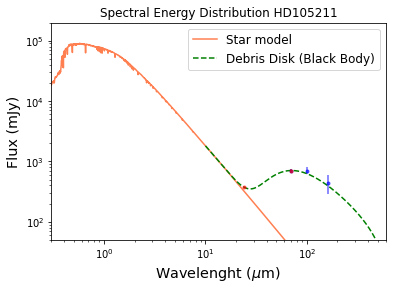

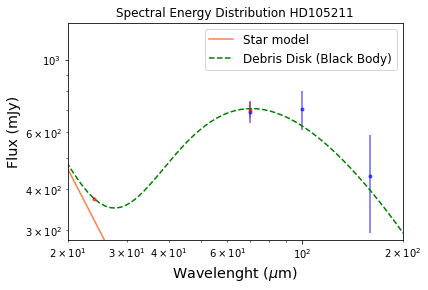

In [28]:
f=open("HD105211.model","r")
lines=f.readlines()
lines = lines[2:]


lam_mod=[]
flux_mod=[]

for data in lines:
    data=data.split()
    lam_mod.append(float(data[0]))
    
    
for data in lines:
    data=data.split()
    flux_mod.append(float(data[1]))

flux_mod = np.array(flux_mod) * 1e3    
    
#Function
x= np.linspace(10, 1000, 1000, endpoint=True)



interp = spi.interp1d(lam_mod,flux_mod,axis=0, fill_value="extrapolate")
photosphere = interp(x)



#mod_mbb = modified_blackbody(x, *result_modified.x) + photosphere
mod_bb = blackbody(x, *result_blackbody.x) + photosphere

lam_p = lam[0:2]
lam_m = lam [2:]
PACS = flux[0:2]
MIPS = flux[2:]
ferr_p = ferr[0:2]
ferr_m = ferr [2:]

plt.figure(1)
plt.errorbar(lam_m, MIPS, yerr=ferr_m, fmt='.', color='blue', alpha=0.6)
plt.errorbar(lam_p, PACS, yerr=ferr_p, fmt='.', color='red', alpha=0.6)
plt.plot(lam_mod,flux_mod, color='coral', label='Star model')
#plt.plot(x, (modified_blackbody(x,*result_modified.x)+photosphere)),label="Debris Disk (Modified)", color ="black",linestyle="dashed")
plt.plot(x, mod_bb,label="Debris Disk (Black Body)", color ="green",linestyle="dashed")
plt.xlabel('Wavelenght ($\mu$m)', fontsize='x-large')
plt.ylabel('Flux (mJy)', fontsize='x-large')
plt.legend(loc='best', fontsize='large')
plt.title("Spectral Energy Distribution HD105211")
plt.yscale("log")
plt.xscale("log")
plt.xlim([3e-1,600 ])
plt.ylim([5e1,2e5])
plt.savefig("SED.png", bbox_inches='tight')

plt.figure(2)
plt.errorbar(lam_m, MIPS, yerr=ferr_m, fmt='.', color='blue', alpha=0.6)
plt.errorbar(lam_p, PACS, yerr=ferr_p, fmt='.', color='red', alpha=0.6)
plt.plot(lam_mod,flux_mod, color='coral', label='Star model')
#plt.plot(x, (modified_blackbody(x,*result_modified.x)+photosphere)),label="Debris Disk (Modified)", color ="black",linestyle="dashed")
plt.plot(x, mod_bb,label="Debris Disk (Black Body)", color ="green",linestyle="dashed")
plt.xlabel('Wavelenght ($\mu$m)', fontsize='x-large')
plt.ylabel('Flux (mJy)', fontsize='x-large')
plt.legend(loc='best', fontsize='large')
plt.title("Spectral Energy Distribution HD105211")
plt.yscale("log")
plt.xscale("log")
plt.xlim([2e1,2e2 ])
plt.ylim([2.8e2,1.3e3])
plt.savefig("SEDZoom.png", bbox_inches='tight')

In [24]:
PACS, MIPS

(array([374.6, 702. ]), array([692. , 704. , 440.3]))

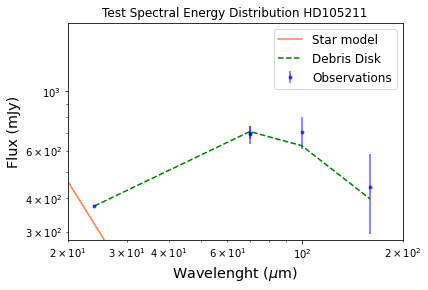

In [9]:
x = np.linspace(0, 1000, 1001, endpoint=True)

plt.figure(2)

flux_disk = blackbody(lam, *result_blackbody.x)

plt.errorbar(lam, flux, yerr=ferr, fmt='.', color='blue', alpha=0.6, label='Observations')
plt.plot(lam_mod,flux_mod, color='coral', label='Star model')
#plt.plot(x, modified_blackbody(x,*result_modified.x),label="Debris Disk (Modified)", color ="black",linestyle="dashed")
plt.plot(lam, blackbody(lam,*result_blackbody.x)+photosphere_ob,label="Debris Disk", color ="green",linestyle="dashed")
plt.xlabel('Wavelenght ($\mu$m)', fontsize='x-large')
plt.ylabel('Flux (mJy)', fontsize='x-large')
plt.legend(loc='best', fontsize='large')
plt.title("Test Spectral Energy Distribution HD105211")
plt.yscale("log")
plt.xscale("log")
plt.xlim([2e1,2e2 ])
plt.ylim([2.8e2,1.8e3])
plt.savefig("EtaCru_SED_IncorrectTest.png")

In [10]:
## Black Body Negative Likelihood Fun.
##   nll_blackbody
## def nll_blackbody(params, lam, flux, ferr, photosphere):
    #temp = params[0]
    #const = params[1]


    #fPred = blackbody(lam, temp, const) + photosphere


    #logLik = -np.sum(stats.norm.logpdf(flux, loc=fPred, scale=ferr))


    #return(logLik) 

param_maxima = [300, 1e20]
param_minima = [10, 1e8] 
                
def lnpriorfn(params):   
    """ Uniform prior probability function """

    if ((params[0] > param_minima[0]) & (params[0] < param_maxima[0]) 
        & (params[1] > param_minima[1]) & (params[1] < param_maxima[1])): 
        return 0 
    else: 
        return -np.inf 
     

def log_probability(params):
    lp = lnpriorfn(params)
    if not np.isfinite(lp):
        return -np.inf
    
    
    return -nll_blackbody(params, lam, flux, ferr, photosphere_ob) + lp

### MCMC

In [11]:
import emcee 


ndim = 2
nsteps = 3000 
nwalkers = 50

pos = result_blackbody.x + 1e-4 * np.random.randn(nwalkers,ndim) 
pos[:,1] = pos[:,1] + 1.0e7*np.random.randn(nwalkers) 
#nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

pos, prob, state = sampler.run_mcmc(pos, nsteps, progress=True);

100%|██████████| 3000/3000 [00:19<00:00, 156.57it/s]


### Corner Plot

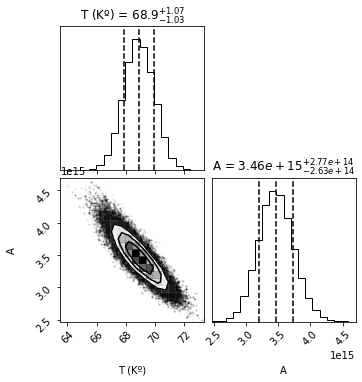

In [29]:
chain= sampler.get_chain(discard=500, flat=True, )

import corner 

fig = corner.corner(chain,labels=["T (Kº)","A"], 
                    quantiles = [0.16, 0.50, 0.84],show_titles=True,
                    title_fmt=".3g")

fig.savefig("SED_corner.png")

Question: The MCMC changes the T and A given by the minimization. Is that OK? 


In [13]:
temp_tau, a_tau=sampler.get_autocorr_time()
if ((nsteps > 50*temp_tau) & (nsteps > 50*a_tau)):
    print ("Correlation times are: \n",
           temp_tau ," = Temperature\n", a_tau, " = Normalization constant\n MCMC steps = 3000\n Chains converge")
else:
    print ("Chanins don't converge")

Correlation times are: 
 27.565160761746466  = Temperature
 28.629192562869168  = Normalization constant
 MCMC steps = 3000
 Chains converge


In [14]:
### Using mcfost to get a theoretical model of the 